## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json

from scipy.stats import gaussian_kde
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots and global variables

In [3]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

model_config = {}
plots_path = ''
dataset_path = ''
stan_file_path = ''
stan_output_dir = ''

#### read models configuration json file

In [4]:
with open("rdm_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())

#### Choose and set model configuration

In [5]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config['plots_folder_name'] + '/'
    dataset_path = datasets_root + model_config['dataset_name']
    stan_file_path = stan_files_root + model_config['stan_file']
    stan_output_dir = saved_models_root + model_config['model_name'] + '/'
    os.path
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('RDM', 'RDM_ct', 'RDM_cd', 'RDM_ndm', 'ANN-R…

In [7]:
model_config

{'model_name': 'RDM_cd',
 'stan_file': 'RDM/RDM_cd.stan',
 'dataset_name': 'fastText_FC.csv',
 'plots_folder_name': 'RDM_cd',
 'transf_params': ['transf_mu_drift_word',
  'transf_mu_drift_nonword',
  'transf_mu_threshold_word',
  'transf_mu_threshold_nonword',
  'transf_mu_ndt']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [8]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,drarp,0,0,0.000000,NW,0.000025,9.999752e-01
1,laud,182,1,2.136932,LF,1.000000,9.540957e-08
2,decremont,0,0,0.000000,NW,0.000771,9.992290e-01
3,gugs,0,0,0.000000,NW,0.000233,9.997666e-01
4,trickery,453,1,2.882899,LF,0.999996,3.610227e-06
...,...,...,...,...,...,...,...
74312,gorphological,0,0,0.000000,NW,0.000168,9.998318e-01
74313,hearse,160,1,3.205648,HF,1.000000,4.410969e-08
74314,appallingly,102,1,1.893894,LF,1.000000,3.650449e-07
74315,furban,0,0,0.000000,NW,0.000531,9.994685e-01


In [9]:
def remove_outliers(df, max_rt, min_rt, std_c=2.5):
    """
    Returns remove outliers from dataframes. Outlier RTs are bigger than
    max_rt and smaller than min_rt. Also RTsthat are out of -/+ (std_c * sd) 
    of mean RT interval are considered as outliers too.

    Parameters
    ----------
        df: pandas dataframe with rt column
        max_rt (float): maximum acceptable rt
        min_rt (float): minimum acceptable rt
        
    Optional Parameters
    ----------
        std_c (float) : Optional
            coefficient to define interval of non-outlier RTs
    
    Returns
    -------
        df: pandas dataframe without outliers  
    """
    mean = df['rt'].mean()
    sd = df['rt'].std()
    lower_thr = mean - std_c*sd
    upper_thr = mean + std_c*sd
    min_bound = max(min_rt, lower_thr)
    max_bound = min(max_rt, upper_thr)
    df = df[df['rt'] >= min_bound]
    df = df[df['rt'] <= max_bound]
    return df

Reading and modifing each behavioral data file and combining all of them into a single behavioral dataframe

In [10]:
Number_Of_Participants = 5
Number_Of_Trials = 500
dataframes = []

for i in range(Number_Of_Participants):
    # Loading each file
    df = pd.read_csv(behavioural_data_root + str(i+1) + "_DATA.LDT", names=['trial', 'string_id', 'string_type', 'accuracy', 'rt', 'string'])
    # Dropping non rows and first two rows that are demographic informations 
    df = df.dropna().drop('string_id', axis=1).drop([0, 1]).iloc[:Number_Of_Trials]
    # Dropping rows with wrong accuracies
    df = df.loc[(df['accuracy'] == '0') | (df['accuracy'] == '1')]
    # Converting columns type to suitable data types
    convert_dict = {'string_type': 'int16',
                    'accuracy': 'int16',
                    'rt': float
                   }

    df = df.astype(convert_dict)
    # Convert RTs to seconds
    df['rt'] = df['rt'].apply(lambda x: x/1000) 
    # Removing Outliers
    df = remove_outliers(df, 3, .2, 2.5)
    # Extracting response of participant from his/her accuracy
    df['response'] = np.logical_not(np.logical_xor(df['string_type'], df['accuracy'])).astype('int')
    df = df.reset_index(drop=True)
    # Particpant number
    df['participant'] = i+1
    # Minimum RT of participant in all trials (is needed for stan code)
    df['minRT'] = df['rt'].min()
    dataframes.append(df)

In [11]:
# Combining dataframes
behavioural_df = pd.concat(dataframes)
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["trial", "string_type", "freq"], axis=1)

In [12]:
behavioural_df.head()

,accuracy,rt,string,response,participant,minRT,label,zipf,category,word_prob,non_word_prob
0,0,0.548,pracker,1,1,0.429,0.0,0.000000,NW,0.000836,9.991643e-01
1,1,0.646,nearside,1,1,0.429,1.0,1.592864,LF,0.998253,1.746930e-03
2,1,0.511,jets,1,1,0.429,1.0,3.645943,HF,1.000000,5.878510e-11
3,1,0.815,vates,0,1,0.429,0.0,0.000000,NW,0.002267,9.977329e-01
4,1,0.680,onward,1,1,0.429,1.0,3.194924,HF,0.999999,1.096722e-06


Predicted probabilities of words and non-words in different conditions in all trials
across participants

In [13]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'non_word_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                        non_word_prob  \
              mean       std count      max           min          mean   
category                                                                  
HF        0.999692  0.002950   441  1.00000  9.458225e-01      0.000308   
LF        0.995130  0.048837   583  1.00000  4.073943e-03      0.004870   
NW        0.002697  0.031031  1196  0.99052  5.035976e-23      0.997303   

                                                  
               std count       max           min  
category                                          
HF        0.002950   441  0.054177  9.513443e-20  
LF        0.048837   583  0.995926  2.297777e-14  
NW        0.031031  1196  1.000000  9.480231e-03

RT and response description of words and non-words in different conditions in all trials
across participants

In [14]:
behavioural_df.groupby(['category']).agg({'rt': ['mean', 'std', 'max', 'min'], 'response': ['mean', 'std', 'max', 'min']})

rt                          response                  
              mean       std    max    min      mean       std max min
category                                                              
HF        0.807853  0.320557  2.551  0.422  0.965986  0.181470   1   0
LF        1.001453  0.416596  2.861  0.470  0.821612  0.383167   1   0
NW        1.083640  0.444531  2.906  0.446  0.153846  0.360952   1   0

## Stan Model and Estimation

Compiling stan model

In [15]:
rdm_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path)

13:16:08 - cmdstanpy - INFO - compiling stan file D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\RDM\RDM_cd.stan to exe file D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\RDM\RDM_cd.exe
13:16:33 - cmdstanpy - INFO - compiled model executable: D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\RDM\RDM_cd.exe
13:16:33 - cmdstanpy - WARNING - Stan compiler has produced 19 warnings:
13:16:33 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Lenovo/AppData/Local/Temp/tmpflrotzcg/tmpwvdad37n.hpp C:/Users/Lenovo/AppData/Local/Temp/tmpflrotzcg/tmpwvdad37n.stan
Warning in 'C:/Users/Lenovo/AppData/Local/Temp/tmpflrotzcg/tmpwvdad37n.stan', line 54, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/Lenovo/Ap

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [16]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df['participant'].to_numpy()                     # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values, for models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models

threshold_priors = [0, 1, 1, 1]          # For all models with LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models without drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
k_priors = [2, 1, 1, 1]                  # For models with sigmoid drift mapping functions (ANN-EAM models)

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'threshold_priors': threshold_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             }

# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [17]:
fit = rdm_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

13:16:33 - cmdstanpy - INFO - Chain [1] start processing
13:16:33 - cmdstanpy - INFO - Chain [2] start processing


Chain [1] method = sample (Default)
Chain [1] sampleChain [2] method = sample (Default)
Chain [1] num_samples = 250

Chain [1] num_warmup = 250
Chain [2] sample
Chain [1] save_warmup = 0 (Default)Chain [2] num_samples = 250

Chain [2] num_warmup = 250Chain [1] thin = 1 (Default)

Chain [1] adapt
Chain [2] save_warmup = 0 (Default)
Chain [2] thin = 1 (Default)
Chain [2] adapt
Chain [2] engaged = 1 (Default)
Chain [2] gamma = 0.050000000000000003 (Default)
Chain [2] delta = 0.80000000000000004 (Default)
Chain [1] engaged = 1 (Default)Chain [2] kappa = 0.75 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)

Chain [1] delta = 0.80000000000000004 (Default)
Chain [2] t0 = 10 (Default)Chain [1] kappa = 0.75 (Default)

Chain [1] t0 = 10 (Default)
Chain [2] init_buffer = 75 (Default)
Chain [2] term_buffer = 50 (Default)
Chain [2] window = 25 (Default)
Chain [2] algorithm = hmc (Default)
Chain [2] hmc
Chain [2] engine = nuts (Default)
Chain [2] nuts
Chain [2] max_depth = 10 (Default)
Ch

13:22:52 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 207.008 seconds (Warm-up)
Chain [1] 171.359 seconds (Sampling)
Chain [1] 378.367 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [2] Iteration: 500 / 500 [100%]  (Sampling)


13:23:24 - cmdstanpy - INFO - Chain [2] done processing
13:23:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Lenovo/AppData/Local/Temp/tmpflrotzcg/tmpwvdad37n.stan', line 13, column 8 to column 72) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmpflrotzcg/tmpwvdad37n.stan', line 30, column 20 to column 74) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmpflrotzcg/tmpwvdad37n.stan', line 168, column 4 to column 91)
	Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Lenovo/AppData/Local/Temp/tmpflrotzcg/tmpwvdad37n.stan', line 13, column 8 to column 72) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmpflrotzcg/tmpwvdad37n.stan', line 34, column 20 to column 68) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmpflrotzcg/tmpwvdad37n.stan', line 168, column 4 to column 91)
Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Lenovo/AppData/Local/Temp/tmpflrot

Chain [2] 
Chain [2] Elapsed Time: 222.277 seconds (Warm-up)
Chain [2] 188.244 seconds (Sampling)
Chain [2] 410.521 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 


13:23:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (2.0%)
	Chain 2 had 2 divergent transitions (0.8%)
	Use function "diagnose()" to see further information.


## Model diagnostics

In [18]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan_results\RDM_cd\RDM_cd-20220908131633_1.csv, D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan_results\RDM_cd\RDM_cd-20220908131633_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
7 of 500 (1.40%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [19]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-890.514000,0.528387,6.670630,-902.115000,-890.255000,-879.676000,159.378,0.443206,0.99735
mu_ndt,-0.127686,0.016719,0.269447,-0.573059,-0.121420,0.304181,259.729,0.722267,1.00500
mu_threshold_word,1.050970,0.017295,0.297934,0.527809,1.066070,1.516480,296.746,0.825205,1.00127
mu_threshold_nonword,1.452040,0.023684,0.359313,0.841885,1.481220,1.989040,230.169,0.640063,1.00475
mu_drift_word[1],3.110250,0.036265,0.502603,2.222010,3.153850,3.870580,192.075,0.534130,1.00783
...,...,...,...,...,...,...,...,...,...
log_lik[2216],-0.238072,0.002948,0.062858,-0.341806,-0.237624,-0.136133,454.770,1.264640,1.00649
log_lik[2217],-0.452047,0.002506,0.059768,-0.543504,-0.453615,-0.352257,569.020,1.582360,1.00608
log_lik[2218],-3.649160,0.009221,0.197713,-4.001610,-3.646140,-3.333000,459.749,1.278490,1.00451
log_lik[2219],0.192105,0.005860,0.135806,-0.044668,0.198829,0.408537,537.020,1.493370,1.00034


In [20]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
219


In [21]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
sd_drift_nonword[1],1.320420,0.096693,0.683450,0.261981,1.262300,2.446900,49.9597,0.138930,1.04416
"z_drift_nonword[5,1]",-0.533857,0.037552,0.740562,-1.810050,-0.499619,0.604304,388.9190,1.081520,1.01487
drift_nonword_t[881],1.290100,0.043923,0.520187,0.370630,1.319550,2.082720,140.2610,0.390045,1.02709
drift_nonword_t[891],1.290100,0.043923,0.520187,0.370630,1.319550,2.082720,140.2610,0.390045,1.02709
drift_nonword_t[898],1.290100,0.043923,0.520187,0.370630,1.319550,2.082720,140.2610,0.390045,1.02709
...,...,...,...,...,...,...,...,...,...
log_lik[1703],-2.176430,0.005359,0.116886,-2.378360,-2.162630,-1.993510,475.6950,1.322840,1.01074
log_lik[1755],-2.108980,0.005165,0.112833,-2.305870,-2.094680,-1.931120,477.2150,1.327060,1.01054
log_lik[1811],-3.480960,0.020356,0.470069,-4.222390,-3.484390,-2.723260,533.2480,1.482880,1.01112
log_lik[2130],-3.717590,0.024589,0.419042,-4.433890,-3.701660,-3.093420,290.4300,0.807639,1.01234


In [22]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.418054,0.029382,0.379284,-0.211875,0.415529,1.027829,228.000634,0.634035,1.020162
std,1.311339,0.017044,0.161670,1.207435,1.313862,1.440747,107.470264,0.298858,0.007447
min,-6.271590,0.004774,0.104531,-7.518090,-6.218130,-5.205900,49.959700,0.138930,1.010010
25%,0.347552,0.014489,0.241712,0.024879,0.295746,0.797763,140.261000,0.390045,1.013360
50%,0.347552,0.043923,0.520187,0.024879,0.295746,0.797763,140.261000,0.390045,1.027090
75%,1.290100,0.043923,0.520187,0.370630,1.319550,2.082720,278.287000,0.773874,1.027090
max,1.320420,0.096693,0.740562,0.370630,1.319550,2.446900,533.248000,1.482880,1.044160


## Check parameters

Loading Model

In [23]:
# fit = cmdstanpy.from_csv(stan_output_dir)

Parameters posterior plots

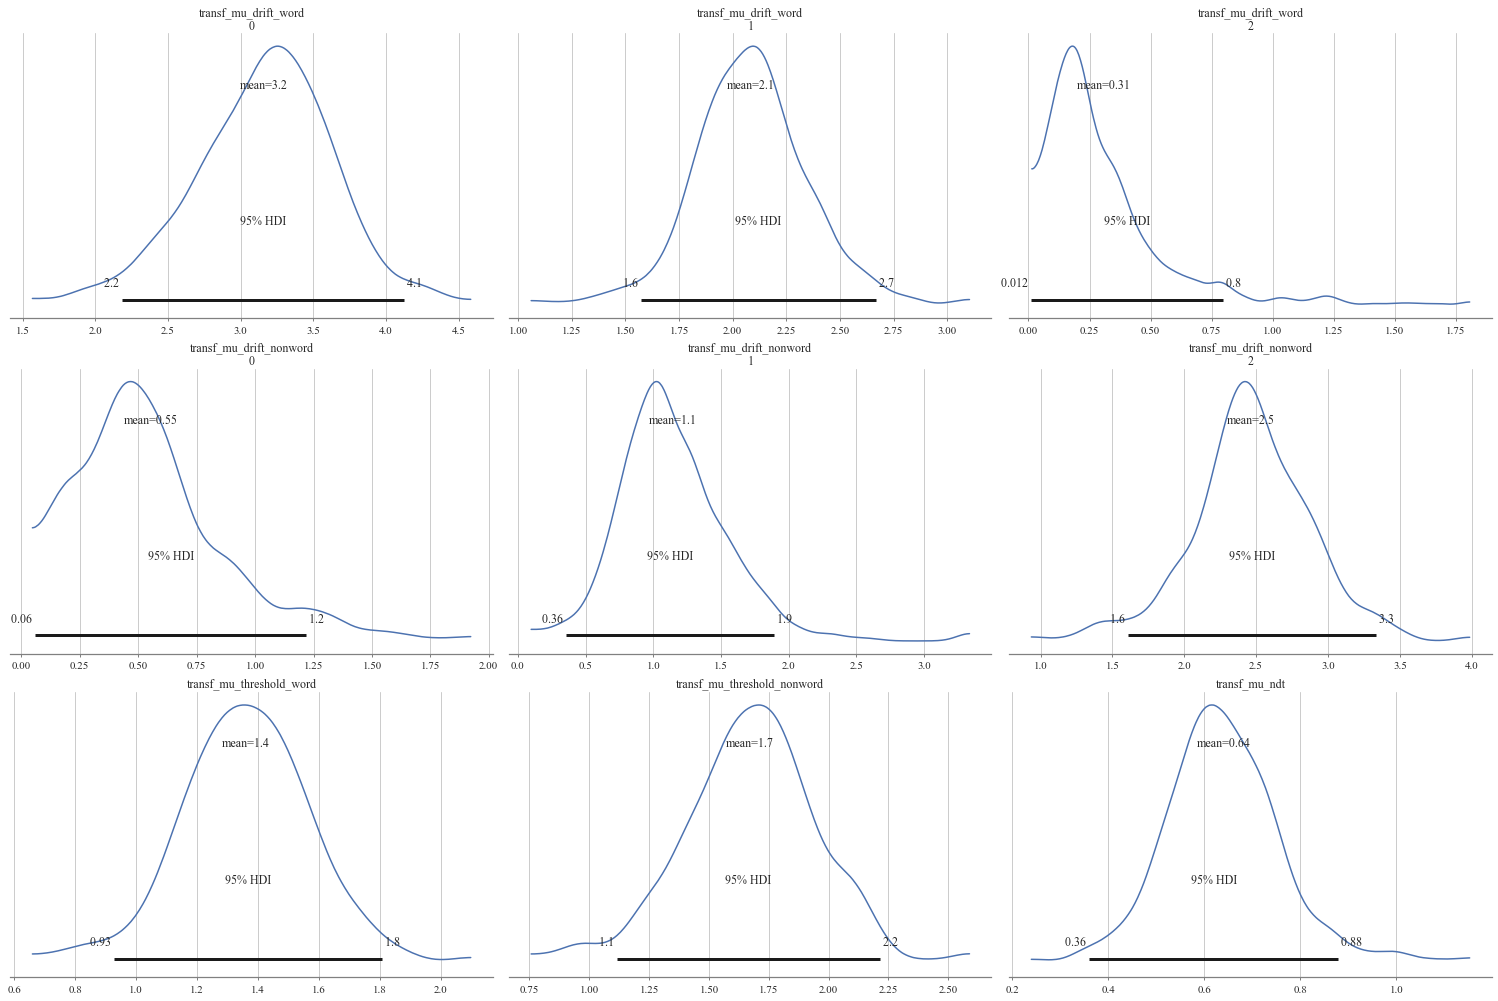

In [24]:
az.plot_posterior(fit, var_names=model_config['transf_params'], hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

Loading model parameters for each trial

In [25]:
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
if model_config['model_name'] != "RDM":
    threshold_t_word = fit.stan_variables()['threshold_t_word']
    threshold_t_nonword = fit.stan_variables()['threshold_t_nonword']
else:
    threshold_t = fit.stan_variables()['threshold_t']
ndt_t = fit.stan_variables()['ndt_t']

#### Models mean parameters in different conditions

In [26]:
HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [27]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

HF words, word drift mean and std:
3.31423785845805 0.1063724967562364
HF words, nonword drift mean and std:
0.621960352549279 0.18972371862387621
LF words word drift mean and std:
2.074140381269296 0.08656211210347467
LF words nonword drift mean and std:
1.1878702225979423 0.10638874219437076
NW words word drift mean and std:
0.3305418370385196 0.08042518790326361
NW words nonword drift mean and std:
2.5135407994314383 0.07377495440467703


In [28]:
if model_config['model_name'] != "RDM":
    HF_condition_w = threshold_t_word[:, behavioural_df['category']=="HF"]
    HF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="HF"]
    LF_condition_w = threshold_t_word[:, behavioural_df['category']=="LF"]
    LF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="LF"]
    NW_condition_w = threshold_t_word[:, behavioural_df['category']=="NW"]
    NW_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="NW"]
else:
    HF_condition = threshold_t[:, behavioural_df['category']=="HF"]
    LF_condition = threshold_t[:, behavioural_df['category']=="LF"]
    NW_condition = threshold_t[:, behavioural_df['category']=="NW"]

In [29]:
if model_config['model_name'] != "RDM":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))
else:
    print('HF words, threshold mean and std:')
    print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))
    print('LF words, threshold mean and std:')
    print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))
    print('NW words, word threshold mean and std:')
    print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

HF words, word threshold mean and std:
1.4551125191836736 0.058095798930433276
HF words, nonword threshold mean and std:
1.895573457464853 0.0671055833793444
LF words word threshold mean and std:
1.4297129090909095 0.056063101448381315
LF words nonword threshold mean and std:
1.86427029386964 0.06467796261099716
NW words word threshold mean and std:
1.437456208160536 0.056380627381414285
NW words nonword threshold mean and std:
1.8570369391789305 0.0643973355518894


In [30]:
HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [31]:
print('HF words ndt_t mean and std:')
print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))
print('LF words ndt_t mean and std:')
print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))
print('Non Words ndt_t mean and std:')
print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

HF words ndt_t mean and std:
0.3393267408752835 0.012619022208655796
LF words ndt_t mean and std:
0.34811737300514584 0.012189022139998722
Non Words ndt_t mean and std:
0.3456087356471571 0.012272478476895898


## Calculating metrics

In [32]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [33]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': -845.1954540557904, 'p_waic': 39.18832931710848, 'waic': 1768.7675667457977, 'waic_se': 108.2573844531626}


## Simulating RDM with estimated parameters

In [34]:
def random_rdm_2A(cor_drift, inc_drift, threshold_word, threshold_nonword, ndt, noise_constant=1, dt=0.001, max_rt=10):
    """ 
    Simulates behavior (rt and accuracy) according to the Racing Diffusion Model.
     
    Parameters
    ----------
    cor_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - correct trials.
    inc_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - incorrect trials.
    threshold : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Threshold of the diffusion decision model.
    ndt : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Non decision time of the diffusion decision model, in seconds.
    
    Optional Parameters
    ----------------
    noise_constant : float, default 1
        Scaling factor of the Racing Diffusion Model.
        If changed, drift and threshold would be scaled accordingly.
        Not to be changed in most applications.
    dt : float, default 0.001
        Controls the time resolution of the Racing Diffusion Model. Default is 1 msec.
        Lower values of dt make the function more precise but much slower.
    max_rt : float, default 10
        Controls the maximum rts that can be predicted.
        Making this higher might make the function a bit slower.
    
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    acc: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated accuracy according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = cor_drift.shape
    acc = np.empty(shape)
    rt = np.empty(shape)
    acc[:] = np.nan
    rt[:] = np.nan

    max_tsteps = max_rt/dt

    x_cor = np.zeros(shape)
    x_inc = np.zeros(shape)

    tstep = 0
    ongoing = np.array(np.ones(shape), dtype=bool)

    stop_race = False

    while np.sum(ongoing) > 0 and tstep < max_tsteps:
        x_cor[ongoing] += np.random.normal(cor_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        x_inc[ongoing] += np.random.normal(inc_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        tstep += 1
        ended_correct = (x_cor >= threshold_word)
        ended_incorrect = (x_inc >= threshold_nonword)

        # store results and filter out ended trials
        if np.sum(ended_correct) > 0:
            acc[np.logical_and(ended_correct, ongoing)] = 1
            rt[np.logical_and(ended_correct, ongoing)] = dt*tstep + ndt[np.logical_and(ended_correct, ongoing)]
            ongoing[ended_correct] = False

        if np.sum(ended_incorrect) > 0:
            acc[np.logical_and(ended_incorrect, ongoing)] = 0
            rt[np.logical_and(ended_incorrect, ongoing)] = dt*tstep + ndt[np.logical_and(ended_incorrect, ongoing)]
            ongoing[ended_incorrect] = False
    return rt, acc

Simulating RDM with estimated parameters

In [35]:
if model_config['model_name'] != "RDM":
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t_word, threshold_t_nonword, ndt_t, noise_constant=1, dt=0.001, max_rt=5)
else:
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t, threshold_t, ndt_t, noise_constant=1, dt=0.001, max_rt=5)

In [36]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [37]:
# Predicted Data
rt_predictions = pd.concat((pd.DataFrame(pp_rt, index=pd.Index(np.arange(1, len(pp_rt)+1))).T, behavioural_df['category']), axis=1)
response_predictions = pd.concat((pd.DataFrame(pp_response, index=pd.Index(np.arange(1, len(pp_response)+1))).T, behavioural_df['category']), axis=1)

# Experiment Data
experiment_data = behavioural_df.loc[:, ['rt', 'response', 'category']]

Separating RT and Response of predicted and experimental data for each condition

In [38]:
HF_data = experiment_data.loc[experiment_data['category']=='HF']
LF_data = experiment_data.loc[experiment_data['category']=='LF']
NW_data = experiment_data.loc[experiment_data['category']=='NW']

HF_pred_rt = rt_predictions.loc[rt_predictions['category']=='HF'].drop(['category'], axis=1)
HF_pred_resp = response_predictions.loc[response_predictions['category']=='HF'].drop(['category'], axis=1)
LF_pred_rt = rt_predictions.loc[rt_predictions['category']=='LF'].drop(['category'], axis=1)
LF_pred_resp = response_predictions.loc[response_predictions['category']=='LF'].drop(['category'], axis=1)
NW_pred_rt = rt_predictions.loc[rt_predictions['category']=='NW'].drop(['category'], axis=1)
NW_pred_resp = response_predictions.loc[response_predictions['category']=='NW'].drop(['category'], axis=1)

## Quantiles Posterior Predictions

In [39]:
quantiles = [.1, .3, .5, .7, .9]
percentiles = np.array(quantiles)*100

In [40]:
# experiment Data quantile
HF_quantile_ex = HF_data['rt'].quantile(quantiles)
LF_quantile_ex = LF_data['rt'].quantile(quantiles)
NW_quantile_ex = NW_data['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = HF_pred_rt.quantile(quantiles, axis=0).T
LF_quantile_pred = LF_pred_rt.quantile(quantiles, axis=0).T
NW_quantile_pred = NW_pred_rt.quantile(quantiles, axis=0).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

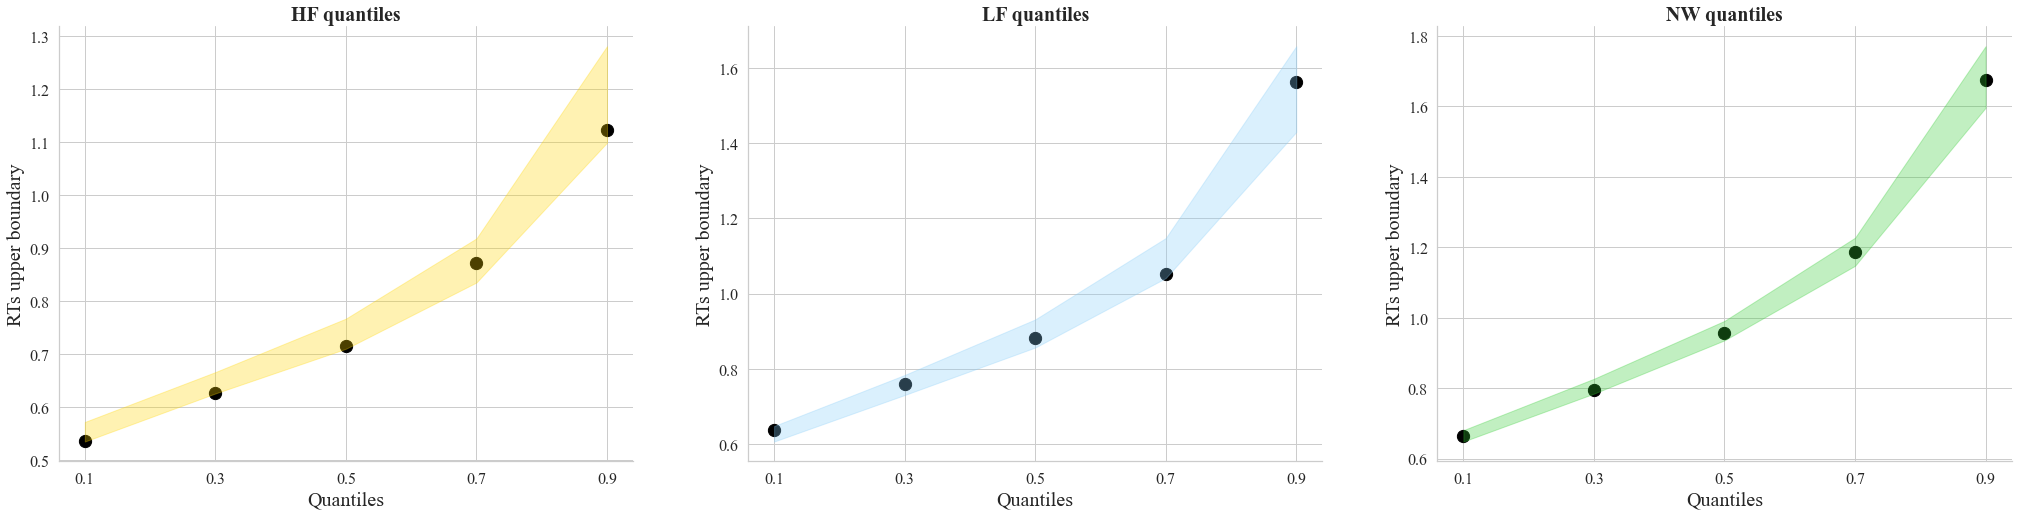

In [41]:
fig, axes = plt.subplots(1,3 , figsize=(35,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=150)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=150)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=150)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=20)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=20)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(16)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 

sns.despine()
plt.savefig(plots_path + 'Quantiles Poseterior.pdf')

## Mean Accuracy and RT Posterior Plots

In [42]:
HF_data_rt_mean = HF_data['rt'].mean()
LF_data_rt_mean = LF_data['rt'].mean()
NW_data_rt_mean = NW_data['rt'].mean()

HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
NW_pred_rt_mean = NW_pred_rt.mean(axis=0)


HF_data_resp_mean = HF_data['response'].mean()
LF_data_resp_mean = LF_data['response'].mean()
NW_data_resp_mean = NW_data['response'].mean()

HF_pred_resp_mean = HF_pred_resp.mean(axis=0)
LF_pred_resp_mean = LF_pred_resp.mean(axis=0)
NW_pred_resp_mean = NW_pred_resp.mean(axis=0)


In [43]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)], color = 'lightsteelblue')

    ax.plot(xd, yd, color='slategray')
    ax.axvline(data_mean, color='red')

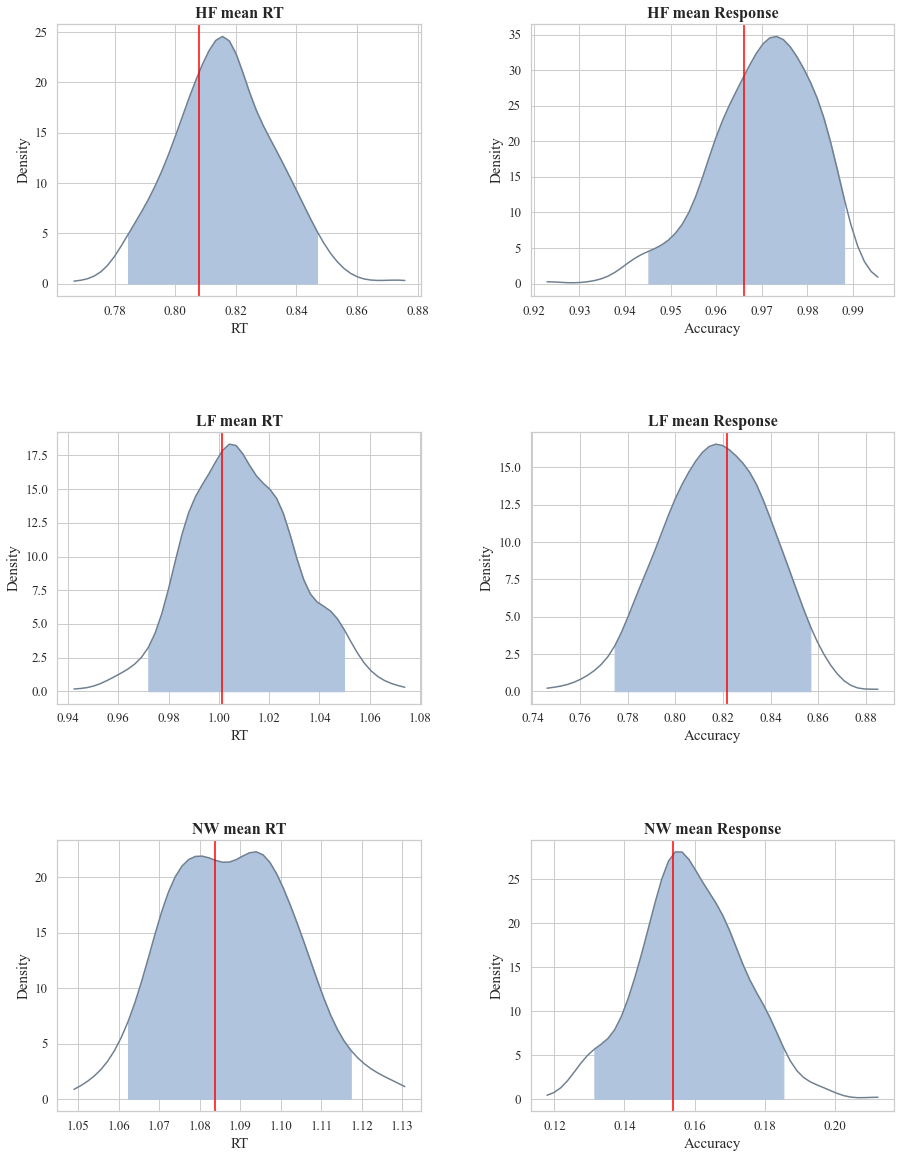

In [44]:
fig, axes = plt.subplots(3,2 , figsize=(15,20))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label.set_fontsize(13) 

plt.savefig(plots_path + 'Mean Accuracy and RT.pdf')